In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import os
#print(os.listdir("../input"))

import time

import matplotlib.pyplot as plt
import seaborn as sns
import gc

%matplotlib inline
path='/Users/alessandrorivello/Kaggle/dados_kaggle/'

In [2]:
# Setting the data types before importing (instead of letting pandas guess it) can improve 
# performance and use less RAM
# Reference: https://www.kaggle.com/yuliagm/how-to-work-with-big-datasets-on-16g-ram-dask
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'days'          : 'uint8',
        'hours'         : 'uint8',
        'minutes'       : 'uint8',
        'seconds'       : 'uint8',
        }

In [3]:
# We delete the attributed_time column since it has a lot of missing values and might not be so informative
# Reference: https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/51411
cols = ['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'days', 'hours', 'minutes','seconds']

In [4]:
# Note that we're using 10_train_timed and not the original file. This file represents 10% of the full train data
# and the column click_time was split into its components days, hours, minutes and seconds. Besides that, we also
# deleted the year and month component saving us a lot of memory space

train=pd.read_csv(path + '10_train_timed.csv', dtype=dtypes, usecols = cols)

In [5]:
dtypes2 = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'days'          : 'uint8',
        'hours'         : 'uint8',
        'minutes'       : 'uint8',
        'seconds'       : 'uint8',
        }

test=pd.read_csv(path + 'test_timed.csv', index_col=0, dtype=dtypes2)

/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
test.head()

,ip,app,device,os,channel,days,hours,minutes,seconds
click_id,,,,,,,,,
0,5744,9,1,3,107,10,4,0,0
1,119901,9,1,3,466,10,4,0,0
2,72287,21,1,19,128,10,4,0,0
3,78477,15,1,13,111,10,4,0,0
4,123080,12,1,13,328,10,4,0,0


In [7]:
train.head()

,ip,app,device,os,channel,is_attributed,days,hours,minutes,seconds
0,103022,3,1,23,379,0,6,14,37,44
1,114221,3,1,19,379,0,6,14,37,59
2,47902,3,1,17,379,0,6,14,48,7
3,23550,3,1,13,379,0,6,14,53,39
4,84644,3,1,19,379,0,6,14,56,49


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18490388 entries, 0 to 18490387
Data columns (total 10 columns):
ip               uint32
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed    uint8
days             uint8
hours            uint8
minutes          uint8
seconds          uint8
dtypes: uint16(4), uint32(1), uint8(5)
memory usage: 299.8 MB


In [9]:

test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18790469 entries, 0 to 18790468
Data columns (total 9 columns):
ip         uint32
app        uint16
device     uint16
os         uint16
channel    uint16
days       uint8
hours      uint8
minutes    uint8
seconds    uint8
dtypes: uint16(4), uint32(1), uint8(4)
memory usage: 430.1 MB


/anaconda3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


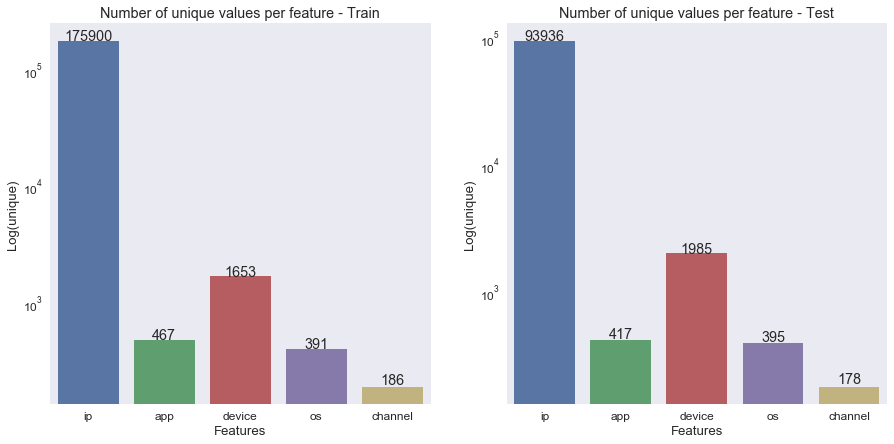

In [10]:
plt.figure(figsize=(10,6))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques_train = [len(train[col].unique()) for col in cols]
uniques_test = [len(test[col].unique()) for col in cols]

sns.set(font_scale=1.2)
sns.set_style('dark')

fig, axs = plt.subplots(1, 2,figsize=(15,7))
graph_train = sns.barplot(cols, uniques_train, ax=axs[0], log=True)
graph_test = sns.barplot(cols, uniques_test, ax=axs[1], log=True)

graph_train.set(xlabel='Features', ylabel='Log(unique)', title='Number of unique values per feature - Train')
graph_test.set(xlabel='Features', ylabel='Log(unique)', title='Number of unique values per feature - Test')

for t, tt, uniq_t, uniq_tt in zip(graph_train.patches, graph_test.patches, uniques_train, uniques_test):
    height_train=t.get_height()
    height_test=tt.get_height()
    graph_train.text(t.get_x()+t.get_width()/2.,
            height_train + 10,
            uniq_t,
            ha="center") 
    graph_test.text(tt.get_x()+tt.get_width()/2.,
            height_test + 10,
            uniq_tt,
            ha="center") 


Como esperado o número de registros únicos é muito maior entre IPs do que entre os outros dados. Achamos esse resultado natural uma vez que um aplicativo muito popular pode ser baixado milhares de vezes; é fácil conceber que existão milhares de hardware com o mesmo OS e assim por diante.
Como o objetivo final será identificar os cliques falsos (aqueles que clicam, mas não fazem dowload), vamos ver como se comprta a taxa de conversão (número de downloads vs número total de cliques) nos dados

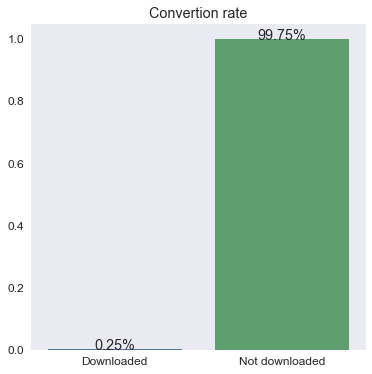

In [11]:
plt.figure(figsize=(6,6))
downl = (train.is_attributed.values == 1).mean()
ndownl = 1 - downl
downloads = [downl, ndownl]
cols = ['Downloaded', 'Not downloaded']

ax = sns.barplot(cols, downloads)
ax.set(title='Convertion rate')

for c, d in zip(ax.patches, downloads):
    height=c.get_height()
    ax.text(c.get_x()+c.get_width()/2.,
            height,
            '{}%'.format(round(d*100,2)),
            ha="center")  

Oberservamos que a taxa de conversão é muito baixa. Apenas 0,25% dos cliques se convertem em verdadeiros downloads! Isso já nos dá alguma evidência que muitos cliques falsos de fato ocorrem. Será que os IPs podem nos ajudar a identificar a fonte desses cliques falsos?

Vamos tentar explorar um pouco mais a identificação dos cliques por IP para responder coisas como:

   * Um IP que clica muitas vezes também baixa muitas vezes?
   * Quão concetrado está o número de cliques em cada IP?

In [12]:
temp = train['ip'].value_counts().reset_index(name='counts')
temp.columns = ['ip', 'counts']
temp[:10]

,ip,counts
0,5348,123470
1,5314,117347
2,73516,77004
3,73487,76840
4,53454,49921
5,114276,42474
6,26995,40440
7,95766,37828
8,17149,31147
9,105475,30513


In [13]:
train= train.merge(temp, on='ip', how='left')

In [14]:
train_ip=train[train['is_attributed']==1].sort_values('counts', ascending=False)
train_ip[:10]

,ip,app,device,os,channel,is_attributed,days,hours,minutes,seconds,counts
10231546,5348,3,2,22,280,1,8,10,20,30,123470
11420008,5348,19,395,21,213,1,8,13,45,25,123470
15110489,5348,19,0,24,268,1,9,5,38,10,123470
5000746,5348,121,1,19,203,1,7,12,50,16,123470
15111255,5348,19,231,24,213,1,9,5,38,18,123470
18238178,5348,9,1,19,127,1,9,15,8,59,123470
4938752,5348,107,1,13,171,1,7,12,37,47,123470
15116229,5348,45,1,19,411,1,9,5,39,9,123470
2866306,5348,19,0,29,347,1,7,5,45,26,123470
5597992,5348,9,1,19,232,1,7,14,42,13,123470


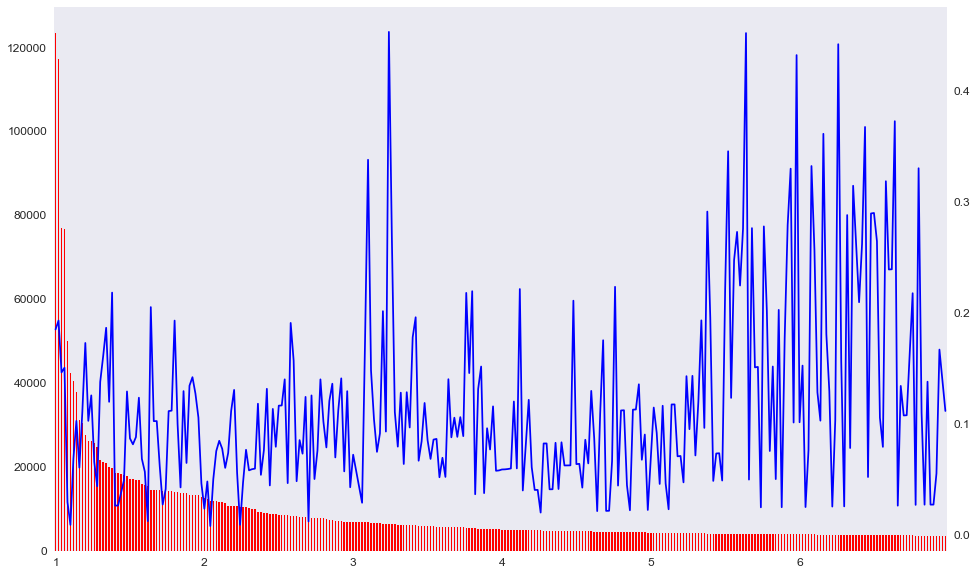

In [45]:
#Gráfico com problemas

clicks = train_ip[['ip','counts']].groupby('ip', as_index=False).mean().sort_values('counts', ascending=False)
downl = train_ip[['ip', 'is_attributed']].groupby('ip', as_index=False).count().sort_values('is_attributed', ascending=False)

clicks = clicks.merge(downl, on='ip', how='left')
clicks['proportion'] = 100*clicks['is_attributed']/clicks['counts']


fig, axs = plt.subplots(figsize=(16,10))


ax = clicks.counts[:300].plot(kind='bar', color='r', ax=axs)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))

ax1 = clicks.proportion[:300].plot(kind='line', color='b', ax=axs, secondary_y=True)
ax1.xaxis.set_major_locator(plt.MaxNLocator(6))


In [17]:
clicks.counts[:10]

0    123470
1    117347
2     77004
3     76840
4     49921
5     42474
6     40440
7     37828
8     31147
9     30513
Name: counts, dtype: int64

In [28]:
downl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36393 entries, 472 to 36392
Data columns (total 2 columns):
ip               36393 non-null uint64
is_attributed    36393 non-null int64
dtypes: int64(1), uint64(1)
memory usage: 853.0 KB
